In [19]:
import os
import boto3
import io
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline  

# Model definition

In [15]:
class PyTorchLRModel(torch.nn.Module):

    def __init__(self, input_dim, output_dim):

        # call class constructor
        super(PyTorchLRModel, self).__init__()

        # use the nn package to create a linear layer
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):

        # Define the "forward" pass of this model. Think of this
        # for now as just the method that takes data input and
        # passes this through the model to create output (i.e., a prediction).
        out = self.linear(x)
        return out

def pytorch_lr_fit(x, y, learning_rate, epochs, lambda1, lambda2):
    """
    Train a (potentially multiple) linear regresison model
    using SGD and pytorch.

    Args:
        x - feature array, a numpy array
        y - response array, a numpy array
        learning_rate - learning rate used in SGD
        epochs - number of epochs for the SGD loop
        lambda1 - the l1 regularization rate
        lambda2 - the l2 regularization rate
    Returns:
        The trained model
    """

    # define the number of features that we expect as input
    # (in input_dimension), and the number of output features
    # (in output_dimension).
    input_dimension = x.ndim
    output_dimension = y.ndim

    # prep the shapes of x and y for pytorch
    if input_dimension == 1:
        x = x[:, np.newaxis]
    else:
        input_dimension = x.shape[1]
    if output_dimension == 1:
        y = y[:, np.newaxis]
    else:
        output_dimension = y.shape[1]

    # initialize the model
    model = PyTorchLRModel(input_dimension, output_dimension)

    # our error/loss function
    criterion = torch.nn.MSELoss()

    # define our SGD optimizer
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda2)

    # loop over our epochs, similar to our previous implementation
    losses = []
    for epoch in range(epochs):

        # increment the epoch count
        epoch +=1

        # define our feature and response variables
        features = Variable(torch.from_numpy(x).float(), requires_grad=True)
        response = Variable(torch.from_numpy(y).float())

        #clear the gradients
        optimiser.zero_grad()

        # calculate the predicted values
        predictions = model.forward(features)

        # calculate our loss
        loss = criterion(predictions, response)

        # add l1 regularization
        if lambda1 > 0.0:
            params = torch.cat([x.view(-1) for x in model.linear.parameters()])
            l1_regularization = lambda1 * torch.norm(params, 1)
            loss += l1_regularization

        # implement our gradient-based updates to our
        # parammeters (putting them "back" into the model
        # via a "backward" update)
        loss.backward()
        optimiser.step()
        
        # append the current loss value
        losses.append(loss.data.item())

    return model, losses

# Import Data

In [3]:
s3_client = boto3.client('s3')
data_bucket_name='datadan'

In [8]:
response = s3_client.get_object(Bucket=data_bucket_name, Key='practical-ai/section2/training.csv')
response_body = response["Body"].read()
training_data = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
training_data.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
2,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
3,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
4,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0


In [32]:
response = s3_client.get_object(Bucket=data_bucket_name, Key='practical-ai/section2/test.csv')
response_body = response["Body"].read()
test_data = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
test_data.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
1,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346,97.0
2,-0.107226,-0.044642,-0.077342,-0.026328,-0.089630,-0.096198,0.026550,-0.076395,-0.042572,-0.005220,137.0
3,0.019913,-0.044642,-0.023451,-0.071085,0.020446,-0.010082,0.118591,-0.076395,-0.042572,0.073480,92.0
4,-0.078165,-0.044642,-0.073030,-0.057314,-0.084126,-0.074277,-0.024993,-0.039493,-0.018118,-0.083920,142.0


# Train model and plot loss vs. epoch number

In [26]:
# pick out our features and response for training
cols = ['bmi', 'map', 'ldl', 'hdl', 'tch', 'glu', 'ltg', 'y']
num_features = len(cols[0:-1])

# scale the features and response
scaler = MinMaxScaler()
train_data = scaler.fit_transform(training_data[cols])

# fit our model
model, losses = pytorch_lr_fit(np.array(train_data[:, 0:num_features]),
        np.array(train_data[:, num_features]), 0.1, 25, 0.0, 0.0)

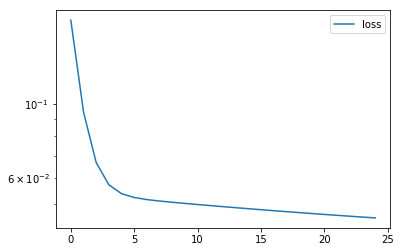

In [27]:
# plot the losses as a function of epoch number
loss_df = pd.DataFrame(losses, columns=['loss'])
loss_df.plot(logy=True)

# Test for various L2 regularization rates 

In [33]:
# pre-process our test data
test_data = scaler.transform(test_data[cols])

# test input for the model and observation tensors
test_input = Variable(torch.from_numpy(test_data[:, 0:num_features]).float())

In [43]:
# the range of regularization rates we will test
rates = np.linspace(0.0005,0.02,100)

# loop over each rate
metrics = []
for rate in rates:
    
    # train model
    model, _ = pytorch_lr_fit(np.array(train_data[:, 0:num_features]),
                                   np.array(train_data[:, num_features]), 0.1, 1000, 0.0, rate)
    
    # evaluate the model
    predictions = model(test_input)
    rmse = math.sqrt(mean_squared_error(predictions.data.numpy(),
                                        test_data[:, num_features]))
    metrics.append(rmse)

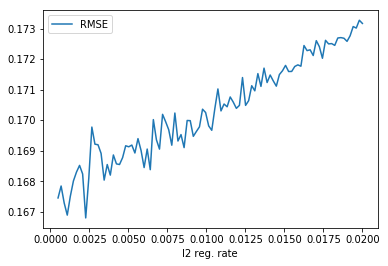

In [44]:
# plot the RMSE value as a function of L2 regularization rate
l2_df = pd.DataFrame(metrics, columns=['RMSE'])
l2_df['l2 reg. rate'] = rates
l2_df.set_index('l2 reg. rate').plot()